In [2]:
from matplotlib import pyplot as plt
from matplotlib import image as img
import numpy as np
import cv2
import os
from matplotlib import pyplot as pl
from subprocess import call
import datetime

## 工具函数（首先运行这个）
## Toolchain(Run this first)

In [3]:
# Toolchain
def frame_preprocess(frame):
    return cv2.blur(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY),(9,9))
def frame_postprocess(frame,method="MORPH"):
    if method=="MORPH":
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))  
        return cv2.morphologyEx(frame, cv2.MORPH_OPEN, kernel,iterations=1) 
    elif method == "BLUR":
        return cv2.blur(frame, (9,9))
class data_queue(object):
    def __init__(self,SIZE):
        self.currsize = 0
        self.maxsize = SIZE if SIZE > 0 else 0
        data = []
        for i in range(self.maxsize):
            data.append(0)
        self.data = data

    def __str__(self):
        string = ''
        for i in range(self.currsize):
            string += str(self.data[i])
            string += ' '
        return string

    def get_mean(self):
        runningsum = 0
        if self.currsize!=0:
            try:
                runningsum = np.zeros(self.data[0].shape)
            except:
                pass
            for i in range(self.currsize):
                runningsum += self.data[i]
            return runningsum / self.currsize
        else:
            return 0

    def get_data(self):
        return self.data[0:self.currsize]

    def add_data(self, newdata):
        if self.currsize < self.maxsize:
            self.data[self.currsize] = newdata
            self.currsize+=1
        else:
            new_data_list = []
            for i in range(self.maxsize-1):
                new_data_list.append(self.data[i+1])
            new_data_list.append(newdata)
            self.data = new_data_list
        return

In [4]:
# 简单测试
MA = data_queue(4)
MA.add_data(np.array([1,1,1,1]))
MA.add_data(np.array([1,2,3,4]))
MA.add_data(np.array([4,3,2,1]))
MA.add_data(np.array([2,2,2,2]))
MA.add_data(np.array([0,0,0,0]))
MA.add_data(np.array([3,3,3,3]))
print(MA)
print(MA.get_data())
print(MA.get_mean())

[4 3 2 1] [2 2 2 2] [0 0 0 0] [3 3 3 3] 
[array([4, 3, 2, 1]), array([2, 2, 2, 2]), array([0, 0, 0, 0]), array([3, 3, 3, 3])]
[2.25 2.   1.75 1.5 ]


## 背景差分
## Background diff

In [5]:
def background_diff(filename, frame_num = -1, bkg_construct_frame = 800, frame_freq = 10, mv_avr_width = 70, post_process = False, video_save_path = 'out.mp4', post_process_method="BLUR"):
    # frame_num 默认是整个视频，可以指定使用的总帧数。bkg_construct_frame是用来构建背景的帧数，也算在 frame_num 里面。
    # 读取源文件并初始化输出文件的编码
    capture = cv2.VideoCapture(filename)
    starttime = datetime.datetime.now()
    fps = capture.get(cv2.CAP_PROP_FPS)
    size = (int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)),
        int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')  #要保存的视频格式 
    output_video = cv2.VideoWriter()
    output_video.open(video_save_path,fourcc, fps//frame_freq, size, False)
    ret, frame = capture.read()
    heat_map = np.zeros(shape=frame_preprocess(frame).shape)
    frame_count = 0
    valid_frame_count = 1
    out_frames = []
    moving_average = data_queue(mv_avr_width)
    # 初始化背景构建器
    fgbg = cv2.createBackgroundSubtractorMOG2()
    while(capture.isOpened()):
        ret, frame = capture.read()
        if (frame_num!=-1):
            if (frame_count>frame_num):
                break
        if frame_count < bkg_construct_frame: 
            try:
                # 把帧添加到背景
                out_frame = fgbg.apply(frame)
                valid_frame_count+=1
            except:
                pass
        else:
            if (frame_count%frame_freq==0): # 取余，每(frame_freq)帧和背景做一次差分
                try:
                    out_frame = fgbg.apply(frame)
                    if post_process:
                        out_frame = frame_postprocess(out_frame,method=post_process_method)
                    heat_map+=out_frame
                    moving_average.add_data(out_frame)
                    h_map_processed = moving_average.get_mean()
                    h_map_processed = cv2.blur(h_map_processed,(9,9)).astype(np.uint8)
                    output_video.write(h_map_processed)                   
                    out_frames.append(h_map_processed)
                    valid_frame_count+=1
                except:
                    break
        frame_count+=1
    output_video.release()
    capture.release()
    heat_map = heat_map/valid_frame_count
    heat_map.astype(np.uint8)
    endtime = datetime.datetime.now()
    if os.name=='posix':
        cmd = 'display notification \"' + \
            "Conversion done within " + str((endtime - starttime).seconds) + " seconds." + '\" with title \"Jupyter Notebook\"'
        call(["osascript", "-e", cmd])
    note = 'Conversion done within %s seconds.' % str((endtime - starttime).seconds)
    print(note)
    return cv2.equalizeHist(heat_map.astype(np.uint8)), out_frames

In [6]:
def select_from_heatmap(hmap,FILENAME):
    hmap = cv2.equalizeHist(hmap.astype(np.uint8))
    SQUARE_THRESHOLD = 200
    capture = cv2.VideoCapture(FILENAME)
    ret, sample_frame = capture.read()
    capture.release()
    hmap_contour = cv2.equalizeHist(hmap.astype(np.uint8))
    c = cv2.findContours(hmap_contour,mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_SIMPLE)
    for j in c[0]:
        x, y, w, h = cv2.boundingRect(np.array(j))
        if w*h>SQUARE_THRESHOLD:
            cv2.rectangle(hmap_contour, (x,y), (x+w,y+h), (153,0,0), 5)
            cv2.rectangle(sample_frame, (x,y), (x+w,y+h), (153,0,0), 5) 
    return hmap_contour,sample_frame

## 使用说明
background_diff() 调用了 opencv 的背景差分器，输入文件名返回累积热力图和所有的热力图。可以指定生成用的总帧数，以及是否调用 frame_postprocess()进行平滑处理。默认保存一个 out.mp4 在同一目录下，内容是处理出来的差分的每一帧。
生成的热力图可以传入select_from_heatmap()进行可视化，同时需要输入原视频的文件地址。这一函数寻找热力图中的外轮廓线并以此为基准框出所有面积大于设定阈值的轮廓。函数会返回两张图像，一张为热力图中框出的活动区域，另一张为原视频截取第一帧框出的活动区域（两个区域是一致的）：
- 后处理用 BLUR （高斯模糊）效果比用 MORPH 好。MORPH 容易丢掉中等大小的点，包括运动较少的区域，但 BLUR 基本上不会丢点。之前丢失主要就是用 MORPH 做了后处理造成的。
- 关于跳帧，看下来更多只是增加了性能。但是如果间隔的帧数太多容易造成静止的背景反而在热力图中很亮，估计和光线等因素有关系。7-10帧基本不影响结果，而且可以计算快很多。
- 关于背景构建帧，这里用了 800 帧。少一些也行，这些帧数不计入热力图的累积，也没有太大影响。
- 关于滑窗宽度，这里使用了 70 帧作为窗口宽度，根据 25 FPS 的帧率以及 7 帧的跳帧频率，这个滑窗等价于覆盖了19.6 秒。使用时也可根据输入的帧率不同进行调整，理念是：20~30 秒的时间内，有人的区域基本上一定会有运动。如果滑窗过长，走动以及其他大范围动作等可能会对一个区域留下长时间的影响。

### Usage
background_diff() uses background subtractor of OpenCV, with file path as input, it returns a cumulative heat map and a list of all single-frame heatmaps. Users can specify the total frame numbers that it reads from the original file, and whether to use frame_postprocess() to reduce noise. The function saves out.mp4 at the path where code is runned byuu default, its content is the diffenentiated frames.
The generated heat map can be used as inpu to select_from_heatmap() for visualization, and the file path of the original video is also required. This function finds the outer contours of the heat map and use rectangles to enclose all shapes that has a area that is larger then the preset threshold. It returns two images: the first is the annotated heat map, the second is a sample frame from the original file annotated.
- For post process, BLUR is better that MORPH. MORPH may lose medium sized movements.
- For frames to jump, it makes the algorithm run faster, but have only limited effect on improving the performance. Too much frame to jump at once will even make the static structures in the background become too bright. 7~10 frames at once works well.
- For background construct frames, we use 800 here, but this does not matter too much. 
- For the moving average width, we use 70 here. With FPS at 25 and picking one frame from each 7, this moving average covers 19.6 seconds. The general idea is to make the moving average cover a 20~30 seconds period, so that any movements can be detected. Too large a width causes movements like passing-by leave too much effect.

### background_diff_v3()效果
### Effect of background_diff_v3()

Conversion done within 110 seconds.


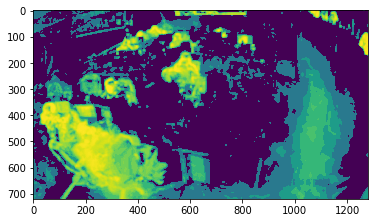

In [10]:
hmap,o_frame = background_diff(filename='ch06_20190201110346.mp4',frame_num=-1,bkg_construct_frame=800,frame_freq=7,post_process=True)
plt.imshow(hmap)

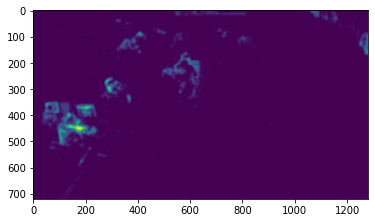

In [11]:
a = o_frame[250]
plt.imshow(a)

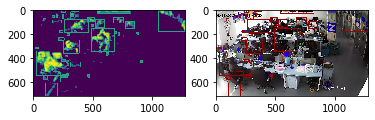

In [12]:
h,s=select_from_heatmap(o_frame[250],'ch06_20190201110346.mp4')
plt.subplot(1,2,1)
plt.imshow(h)
plt.subplot(1,2,2)
plt.imshow(s)
plt.imsave("hmap.png",h)
plt.imsave("out.png",s)

In [13]:
len(o_frame)

1227